# Thermostability and antibody neutralization analysis

In [1]:
import os 
import sys 

from Bio import AlignIO
import pandas as pd 
pd_idx =pd.IndexSlice
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr


from common import mm_to_inch,load_axis_contacts
%reload_ext autoreload
%autoreload 2
sys.path.append('../x01_process_data/')
import x02_load_dataframes
import x03_compute_selections

sys.path.append('../settings/')
# from paths_new import FIGURES_DIR
from common import DESIRED_AA_ORD
from common import codon_to_aa_selector
from paper_settings import PAPER_PRESET
from paper_settings import PAPER_FONTSIZE
from paper_settings import save_fig


sns.set(**PAPER_PRESET)

In [2]:
package_data = x02_load_dataframes.load_packaging_df()
tm_data = x02_load_dataframes.load_thermostability_df()

In [3]:
tm_selection_dict = x03_compute_selections.compute_tm_selection(package_data, tm_data,wt_norm=True,sum_all=True)

In [4]:
tma_aa_selection = tm_selection_dict['aa_selection']
tma_barcode_selection = tm_selection_dict['barcode_selection']
tma_aa_mean = tma_aa_selection.loc[:,pd_idx[:,['67']]].groupby(level='virus', axis=1).mean()
tma_aa_mean.head()

virus                           CMV2      Rep2
abs_pos aa wt_bc lib_type                     
1.0     *  0     sub        0.803975  0.506584
        -  0     del             NaN       NaN
        A  0     sub        0.112274  0.676374
        C  0     sub        1.073104  0.488647
        D  0     sub       19.535643       NaN

In [5]:
package_aa_sel = x03_compute_selections.compute_packaging_selection(package_data, level='aa')
package_barcode_sel = x03_compute_selections.compute_packaging_selection(package_data, level='barcode')
tm_aa_filtered = codon_to_aa_selector(
    package_aa_sel[package_aa_sel[('CMV','0')]>.5], tma_aa_selection)

package_aa_sel_filtered = codon_to_aa_selector(
    package_aa_sel[package_aa_sel[('CMV','0')]>.5], package_aa_sel)

tm_barcode_filtered = codon_to_aa_selector(
    package_aa_sel[package_aa_sel[('CMV','0')]>.5], tma_barcode_selection)



['abs_pos', 'aa', 'lib_type']
['abs_pos', 'aa', 'lib_type']
['abs_pos', 'aa', 'lib_type']


/home/ubuntu/repos/AAV2scan-paper/venv/lib/python3.6/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [6]:
package_aa_sel_filtered_all = package_aa_sel_filtered.iloc[:,:2]
package_aa_sel_filtered_all.columns = package_aa_sel_filtered_all.columns.droplevel(1)
package_aa_sel_filtered_all.index = package_aa_sel_filtered_all.index.droplevel(2)
package_aa_sel_filtered_all.head()

CMV       Rep
abs_pos aa lib_type                    
1.0     M  sub       1.162297  1.017629
1.5     A  ins       0.738688  0.466243
        G  ins       0.506037  0.278422
2.0     A  sub       0.962769  0.254804
           sub            NaN       NaN

In [7]:
tma_aa_mean.index = tma_aa_mean.index.droplevel(2)
tma_aa_mean.head()

virus                     CMV2      Rep2
abs_pos aa lib_type                     
1.0     *  sub        0.803975  0.506584
        -  del             NaN       NaN
        A  sub        0.112274  0.676374
        C  sub        1.073104  0.488647
        D  sub       19.535643       NaN

In [8]:
tm_package_compare = package_aa_sel_filtered_all.join(tma_aa_mean,how='inner')
tm_package_compare.dropna(inplace=True)
tm_package_compare.head()

CMV       Rep      CMV2      Rep2
abs_pos aa lib_type                                        
1.0     M  sub       1.162297  1.017629  0.875946  1.046950
1.5     A  ins       0.738688  0.466243  0.581564  0.734899
        G  ins       0.506037  0.278422  0.722526  1.500956
2.0     A  sub       0.962769  0.254804  1.684666  4.947548
2.5     A  ins       0.659602  0.314683  0.731344  0.837111

### histogram of selection values across temperatures

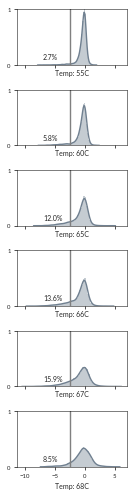

In [9]:
tms_good = ['55','60','65','66','67','68']
fig, axes = plt.subplots(ncols=1, nrows=6, sharex=True, sharey=True, figsize=(2,7))
for tm, ax in zip(tms_good, axes.flatten()):
    tm_in = tm_aa_filtered.groupby(
    level=['abs_pos', 'aa', 'wt_bc']).mean().xs(
        ('CMV2', tm), level=['virus','tm'], axis=1).dropna().apply(np.log2)
    count = tm_in[tm_in<-2.5].count()
    percent_in_tail = (float(count) / tm_in.count() ).values[0]
    sns.distplot(tm_aa_filtered.groupby(
    level=['abs_pos', 'aa', 'wt_bc']).mean().xs(
        ('CMV2', tm), level=['virus','tm'], axis=1).dropna().apply(np.log2),ax=ax,axlabel="Temp: %sC" % (tm),color='slategray')
    ax.plot([-2.5,-2.5],[0,1],c='grey')
    ax.text(-7,0.1,"%.01f%%" % (percent_in_tail*100),size=7)
    ax.set_ylim(0,1)
    ax.set_yticks([0,1])
plt.tight_layout()

### positional frequency of mutations in the left tail of selection distribution - less than log2(-2.5) 

/home/ubuntu/repos/AAV2scan-paper/venv/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


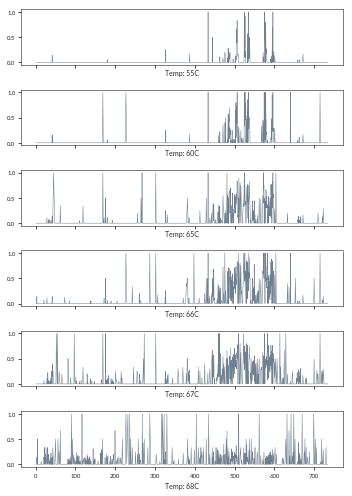

In [10]:
tm_aa_left_tail = tm_aa_filtered[tm_aa_filtered < (2**-2.5)]
fig, axes = plt.subplots( nrows=6, sharex=True, sharey=True, figsize=(5,7))
for tm, ax in zip(tms_good, axes.flatten()):
    ax.plot(tm_aa_left_tail.groupby(level='abs_pos').apply(
        lambda x: x.count()/len(x)).xs(('CMV2', tm), level=['virus', 'tm'], axis=1),c='slategray',linewidth=.5)
    ax.set_xlabel("Temp: %sC" % (tm))
plt.tight_layout()

### focus on temperature 65C, the measured Tm for AAV2

In [11]:
tm_65_percents = tm_aa_left_tail.groupby(level='abs_pos').apply(
        lambda x: x.count()/len(x)).xs(('CMV2', tm), level=['virus', 'tm'], axis=1).reset_index()
tm_65_percents.columns = tm_65_percents.columns.droplevel(1)
tm_65_percents_subs = tm_65_percents[tm_65_percents['abs_pos'].isin(np.arange(0,735))]
tm_65_percents_subs['abs_pos']  = tm_65_percents_subs['abs_pos'].apply(int)

/home/ubuntu/repos/AAV2scan-paper/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### load known AAV2 contacts from VIPERDB 
add selection values for each contact  
website: http://viperdb.scripps.edu/

In [12]:
contacts_df = load_axis_contacts()
contacts_df_with_tm_freq =  contacts_df.merge(
    tm_65_percents_subs, left_on='res1_vp', right_on='abs_pos').merge(
    tm_65_percents_subs, left_on='res2_vp', right_on='abs_pos')
contacts_df_with_tm_freq.sort_values('CMV2_x',ascending = False).head()

,Residue1-Residue2,Type1-Type2,A1-A6 (I-2),A1-A7 (I-3),A1-A2 (I-5),A1-A12 (I-5),Residue1_pdb,Residue2_pdb,res1_vp,res2_vp,abs_pos_x,CMV2_x,abs_pos_y,CMV2_y
109,ASN180-THR202,P-P,NaN,NaN,A2-A1,NaN,180,202,317,339,317,1.0,339,0.0
253,ASN298-HSD221,P-B,NaN,A1-A7,NaN,NaN,298,221,435,358,435,1.0,358,0.0
567,GLN562-THR564,P-P,A1-A6,NaN,NaN,NaN,562,564,699,701,699,1.0,701,0.0
124,ARG267-ASN180,B-P,NaN,NaN,A1-A2,NaN,267,180,404,317,404,1.0,317,1.0
561,GLN562-GLN160,P-P,A6-A1,NaN,NaN,NaN,562,160,699,297,699,1.0,297,0.0


subset contacts at two-fold axis

In [13]:
two_fold = contacts_df_with_tm_freq[['A1-A6 (I-2)', 'CMV2_x', 'CMV2_y', 'abs_pos_x', 'abs_pos_y']].dropna()
two_fold_deduped = pd.concat([pd.concat([two_fold['CMV2_x'],two_fold['CMV2_y']] ), 
pd.concat([two_fold['abs_pos_x'],two_fold['abs_pos_y']] )],axis=1).drop_duplicates()
two_fold_deduped.head()

,0,1
69,0.0,695
92,0.0,293
93,0.0,294
94,0.0,297
95,0.5,700


subset three-fold axis

In [14]:
three_fold = contacts_df_with_tm_freq[['A1-A7 (I-3)', 'CMV2_x', 'CMV2_y', 'abs_pos_x', 'abs_pos_y']].dropna()

In [15]:
three_fold_deduped = pd.concat([pd.concat([three_fold['CMV2_x'],three_fold['CMV2_y']] ), 
pd.concat([three_fold['abs_pos_x'],three_fold['abs_pos_y']] )],axis=1).drop_duplicates()
three_fold_deduped.head()

,0,1
16,0.0,692
49,0.0,260
50,0.0,272
51,0.0,376
52,0.0,378


subset five-fold axis

In [16]:
five_fold_1 = contacts_df_with_tm_freq[['A1-A2 (I-5)', 'CMV2_x', 'CMV2_y', 'abs_pos_x', 'abs_pos_y']].dropna()
five_fold_1.head()

,A1-A2 (I-5),CMV2_x,CMV2_y,abs_pos_x,abs_pos_y
0,A1-A2,0.5,0.0,218,223
1,A1-A2,0.0,0.0,407,223
2,A2-A1,0.0,0.0,221,221
3,A1-A2,1.0,0.0,404,221
4,A2-A1,0.0,1.0,221,404


In [17]:
five_fold_deduped = pd.concat([pd.concat([five_fold_1['CMV2_x'],five_fold_1['CMV2_y']] ), 
pd.concat([five_fold_1['abs_pos_x'],five_fold_1['abs_pos_y']] )],axis=1).drop_duplicates()
five_fold_deduped.head()

,0,1
0,0.5,218
1,0.0,407
2,0.0,221
3,1.0,404
5,0.0,225


### P-Value 3-fold contacts vs all other positions

first subset three-fold vs everything else

In [18]:
not_three_fold = tm_65_percents_subs[~tm_65_percents_subs['abs_pos'].isin(three_fold_deduped[1])]
not_three_fold.head()

virus,abs_pos,CMV2
0,1,0.000000
2,2,0.000000
4,3,0.142857
6,4,0.000000
8,5,0.500000


In [19]:
not_three_fold['CMV2'].mean() - three_fold_deduped[0].mean()

0.0003640731791881707

In [20]:
not_three_fold_proportion = (len(not_three_fold.loc[not_three_fold['CMV2'] > 0]) / len(not_three_fold))
three_fold_proportion = len(three_fold_deduped.loc[three_fold_deduped[0] > 0]) / len(three_fold_deduped)
print (three_fold_proportion)
print (not_three_fold_proportion)
three_fold_proportion/not_three_fold_proportion

0.40782122905027934
0.35877862595419846


1.1366932128848213

In [21]:
import scipy.stats as stats
def two_proprotions_confint(success_a, size_a, success_b, size_b, significance = 0.05):
    """
    Parameters
    ----------
    success_a, success_b : int
        Number of successes in each group

    size_a, size_b : int
        Size, or number of observations in each group

    significance : float, default 0.05

    Returns
    -------
    prop_diff : float
        Difference between the two proportion

    confint : 1d ndarray
        Confidence interval of the two proportion test
    """
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    var = prop_a * (1 - prop_a) / size_a + prop_b * (1 - prop_b) / size_b
    se = np.sqrt(var)

    # z critical value
    confidence = 1 - significance
    z = stats.norm(loc = 0, scale = 1).ppf(confidence + significance / 2)

    # standard formula for the confidence interval
    # point-estimate +- z * standard-error
    prop_diff = prop_b - prop_a
    confint = prop_diff + np.array([-1, 1]) * z * se
    return prop_diff, confint

In [22]:
null_obs = len(not_three_fold)
null_successes = len(not_three_fold.loc[not_three_fold['CMV2'] > 0]) 
threefold_obs = len(three_fold_deduped)
threefold_sucesses = len(three_fold_deduped.loc[three_fold_deduped[0] > 0])

two_proprotions_confint(success_a=threefold_sucesses, 
                        size_a=threefold_obs, 
                        success_b=null_successes, 
                        size_b=null_obs, 
                        significance = 0.00000000000001)

(-0.04904260309608088, array([-0.3763194 ,  0.27823419]))

### Antibody Analysis

In [23]:
antibody_counts = x02_load_dataframes.load_antibody_df()
antibody_counts.head()

count  \
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon barcode                       
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA    CACTGTCACACACTGACACT   23.0   
                                                                              CTGTGAGTGTGAGAGACACT   31.0   
                                                               TAG   *-TAG    CTCTCACACAGTGAGTCTGA    1.0   
                                                                              CAGAGACAGAGTCTGTCACT   10.0   
                                                               TGA   *-TGA    ACACTGTCTCTGTCAGACAG   57.0   

                                                                                                    count.1  
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon barcode                        
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA    CACTGTCACACACTGACACT     39.0  
                                                                              CTGTGAGTGTGAGAGACACT     42.0  
                                                               TAG   *-TAG    CTCTCACACAGTGAGTCTGA      2.0  
                                                                              CAGAGACAGAGTCTGTCACT      8.0  
                                                               TGA   *-TGA    ACACTGTCTCTGTCAGACAG     89.0

In [24]:
antibody_selection_df= x03_compute_selections.compute_antibody_selection(
            ab_counts=antibody_counts, package_counts=package_data, wt_norm=True)
antibody_selection_df.head()

count   count.1
abs_pos aa wt_bc lib_type                    
1.0     *  0     sub       0.701798  0.985308
        -  0     del            NaN       NaN
        A  0     sub       0.462160  0.591185
        C  0     sub       0.756812  1.243935
        D  0     sub       0.368794       NaN

### histogram of a20 interacting residues vs not 

mannwhitney test pval = 1.2760498469718762e-22
effect size: -1.3496786528656872


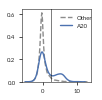

In [25]:
a20_postions_subs = np.array([261,262,263,264,384,385,708,717,258,253,254,658,659,660,548,556])

def plot_a20_dist(ab_aa_df,
#                   hek_or_cre='HEK',
                  plot_wt_random = True,
                  plot_zoom=False,
                  legend_on=True,
                  figname=None, 
                  return_values=False):

    fig = plt.figure(figsize=[1.5,1.5])
    if plot_wt_random:
        wt = ab_aa_df.mean(axis=1).apply(np.log2).dropna()
        sns.kdeplot(ab_aa_df.mean(axis=1).apply(np.log2).dropna(), label='Other',
                    alpha=.9,color='gray', **{'linestyle':'dashed'})
    a20 = ab_aa_df.loc[a20_postions_subs].mean(axis=1).apply(np.log2).dropna()
    sns.kdeplot(ab_aa_df.loc[a20_postions_subs].mean(axis=1).apply(np.log2).dropna(), label='A20')
    print ('mannwhitney test pval = %s' % stats.mannwhitneyu(wt,a20)[1])
    print ('effect size: %s' % (wt.mean()- a20.mean()) )
    plt.xlabel("")
    plt.ylabel('')
    plt.plot([2.5,2.5],[0,2],c='black',lw=.5)
    if plot_zoom:
        plt.ylim([0,.5])
        plt.yticks([])
    if legend_on:
        plt.legend().set_visible(legend_on)
        plt.legend(bbox_to_anchor=(.4825,1),frameon=False)
    else:
        plt.legend().set_visible(legend_on)
    plt.tight_layout()
    if figname:
        figpath =  os.path.join(FIGURES_DIR, figname)
        save_fig(fig, figpath)
    if return_values:
        return wt, a20

plot_a20_dist(antibody_selection_df,figname = None)

mannwhitney test pval = 1.2760498469718762e-22
effect size: -1.3496786528656872


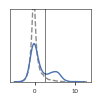

In [26]:
wt, a20 = plot_a20_dist(antibody_selection_df,plot_zoom=True,legend_on=False, 
              figname = None, return_values=True)

### effect size and p-value for known a20 interacting positions vs not

In [27]:
wt_successes = len(wt[wt > 2.5])
wt_obs = len(wt)
a20_successes = len(a20[a20>2.5])
a20_obs = len(a20)
proportion_a20 =   a20_successes / a20_obs
proportion_wt =   wt_successes / wt_obs
print ('proportion wt: %s' %proportion_wt )
print ('proportion a20: %s' %proportion_a20 )
print ('effect size: %s' % (proportion_a20 / proportion_wt))

proportion wt: 0.04938898480078535
proportion a20: 0.2776203966005666
effect size: 5.6210994763381334


In [28]:
two_proprotions_confint(success_a=wt_successes,
                        size_a=wt_obs, 
                        success_b=a20_successes, 
                        size_b=a20_obs, 
                        significance = 1e-16)


(0.22823141179978124, array([0.03228094, 0.42418188]))

### heatmap of selection values for positions known to interact with a20

In [29]:
antibody_selection_mean = antibody_selection_df.mean(axis=1)
antibody_selection_mean.head()

abs_pos  aa  wt_bc  lib_type
1.0      *   0      sub         0.843553
         -   0      del              NaN
         A   0      sub         0.526672
         C   0      sub         1.000373
         D   0      sub         0.368794
dtype: float64

In [30]:
antibody_selection_mean_for_heatmap = antibody_selection_mean.unstack(0).query("wt_bc==0").query("lib_type.isin(['sub','del'])")
antibody_selection_mean_for_heatmap = antibody_selection_mean_for_heatmap.loc[:,a20_postions_subs]
antibody_selection_mean_for_heatmap.index = antibody_selection_mean_for_heatmap.index.droplevel([1,2])
antibody_selection_mean_for_heatmap = antibody_selection_mean_for_heatmap.reindex(DESIRED_AA_ORD)
antibody_selection_mean_for_heatmap.head()

abs_pos,261,262,263,264,384,385,708,717,258,253,254,658,659,660,548,556
aa,,,,,,,,,,,,,,,,
-,0.392858,4.036138,51.647077,0.810298,0.343895,0.811347,0.461109,0.978609,1.111991,0.535406,0.540898,4.279639,51.651884,2.752704,0.950646,0.474343
I,0.861256,0.715894,23.543040,106.350820,0.674203,0.769473,0.798826,0.457136,1.065353,0.846006,2.166251,0.721707,47.640045,1.413017,0.557835,0.343208
L,0.848378,0.554282,34.496109,49.539701,0.637328,0.612805,1.937052,54.583211,6.654661,1.500038,0.888620,2.728250,41.279340,0.769680,0.820451,0.775035
V,0.987084,0.913277,42.725703,51.994317,0.632139,0.569081,8.235650,20.031644,0.128785,0.610966,2.085785,0.690144,89.211938,0.974633,0.656773,2.576019
A,2.118062,0.747765,15.173111,67.469300,13.683089,0.949139,0.707282,61.874952,18.718226,0.430204,15.060929,2.622297,19.621907,12.323206,0.698850,1.196742


Text(0.5,6.9375,'VP Position')

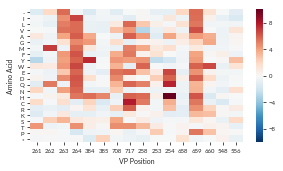

In [31]:
sns.set(**PAPER_PRESET)
fig,ax =plt.subplots(figsize=[3.174*1.5, 1.625*1.5])
sns.heatmap(antibody_selection_mean_for_heatmap.apply(np.log2), cmap='RdBu_r', vmin=-10, vmax=10, ax=ax, yticklabels=True)
ax.set_ylabel("Amino Acid")
ax.set_xlabel("VP Position")

Text(0,0.5,'fraction > cutoff')

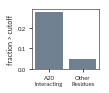

In [32]:
all_residues = antibody_selection_mean.apply(np.log2).dropna()
a20_residues = antibody_selection_mean.loc[a20_postions_subs].apply(np.log2).dropna()

a20_fraction = a20[a20 > 2.5].count() / float(a20.count())
all_residues_fraction = all_residues[all_residues > 2.5].count() / float(all_residues.count())
fig = plt.figure(figsize=(1.2,1.1))
plt.bar(['A20\nInteracting','Other\nResidues'],
        [a20_fraction,
         all_residues_fraction],color='slategrey')
plt.ylabel('fraction > cutoff')